# Which CREs control cell lineage specific genes

Here, we want to assign the CREs to cell lineage specific genes. We are going to use the regression model from the notebook regression_model.ipynb and the assignment of promoters and enhancers per genes from enhancers_promoters_regression.ipynb. Also, from the gene_expression_clustering.ipynb we are going to be using the information about which genes are most expressed in which cell lineages.

In [11]:
import pandas as pd

# Load the two tables
markers_df = pd.read_csv("marker_genes_by_cell_group.csv")     
cre_df     = pd.read_csv("high_conf_filtered.csv")  

# Merge on gene symbol
merged = pd.merge(
    markers_df.rename(columns={"Gene": "gene"}),
    cre_df,
    on="gene",
    how="inner"
)

# Now `merged` contains only those CREs tied to the lineage markers.
#    For each lineage, list its unique CREs:
cres_by_lineage = (
    merged
    .groupby("Group")["peak_ID"]
    .unique()
    .apply(list)
    .reset_index(name="CREs")
)

# Count or rank them by predictive weight:
merged["abs_coef"] = merged["coefficient"].abs()
top_cres = (
    merged
    .groupby("Group")
    .apply(lambda df:
        df.groupby("peak_ID")["abs_coef"]
          .sum()
          .nlargest(10)
          .index
          .tolist()
    )
    .reset_index(name="Top_10_Cres")
)

print(cres_by_lineage)
print(top_cres)


        Group                                               CREs
0  Progenitor  [ImmGenATAC1219.peak_387842, ImmGenATAC1219.pe...
1        Tact  [ImmGenATAC1219.peak_21029, ImmGenATAC1219.pea...
2         abT  [ImmGenATAC1219.peak_508000, ImmGenATAC1219.pe...
        Group                                        Top_10_Cres
0  Progenitor  [ImmGenATAC1219.peak_215414, ImmGenATAC1219.pe...
1        Tact  [ImmGenATAC1219.peak_212966, ImmGenATAC1219.pe...
2         abT  [ImmGenATAC1219.peak_212966, ImmGenATAC1219.pe...


C:\Users\kalin_p\AppData\Local\Temp\ipykernel_2868\1742935559.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df:


In [12]:
merged.head()

,Group,gene,Unnamed: 0,peak_ID,coefficient,r2,distance_to_tss,role,abs_coef
0,Progenitor,Flt3,41052,ImmGenATAC1219.peak_387842,-2.472014,0.847262,981.0,repressor,2.472014
1,Progenitor,Flt3,41053,ImmGenATAC1219.peak_387850,40.321731,0.847262,17275.0,activator,40.321731
2,Progenitor,Flt3,41054,ImmGenATAC1219.peak_387852,-2.587953,0.847262,18772.0,repressor,2.587953
3,Progenitor,Flt3,41055,ImmGenATAC1219.peak_387871,11.187570,0.847262,32993.0,activator,11.187570
4,Progenitor,Flt3,41056,ImmGenATAC1219.peak_387896,16.869341,0.847262,60.0,activator,16.869341


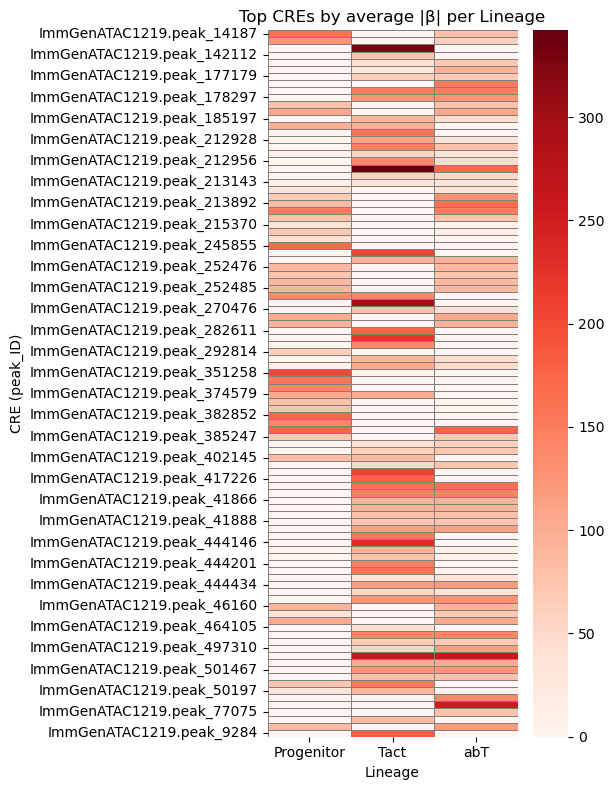

In [ ]:
# Plot top CREs per cell lineage

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# top CREs across all lineages
top_peaks = (
    merged
    .groupby("peak_ID")["abs_coef"]
    .sum()
    .nlargest(100)
    .index
)

# build pivot table
heat = (
    merged[merged["peak_ID"].isin(top_peaks)]
    .groupby(["peak_ID","Group"])["abs_coef"]
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(6,8))
sns.heatmap(heat, cmap="Reds", linewidths=.5, linecolor="gray")
plt.xlabel("Lineage")
plt.ylabel("CRE (peak_ID)")
plt.title("Top CREs by average |β| per Lineage")
plt.tight_layout()
plt.show()


**Fig. 1: Top CREs per average cell lineage**

This heatmap is showing us, for each of our top CREs (rows = peak_ID) and each cell-lineage (columns = Progenitor, Tact, abT), the average absolute regression coefficient ∣𝛽∣ from the peak→expression model. In other words, the deeper the red, the more strongly that CRE predicts the expression of the lineage’s marker genes.

The vertical bar on the right is the color scale, showing us how the shades of red map to numerical values of the heatmap cells. In this case it’s plotting the average absolute regression coefficient ∣β∣ for each CRE–lineage pairing. Lighter red (near zero) means that CRE has almost no predictive weight for that lineage’s marker genes. Darker colors (up toward 300–350 in your figure) means that CRE carried very strong predictive weight—in other words, it was a highly influential regulator of those lineage-specific genes.

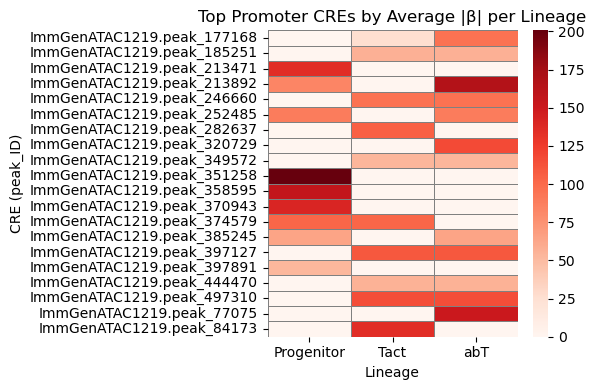

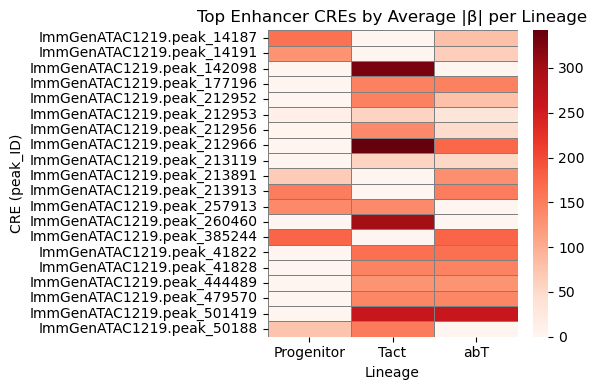

In [ ]:
# Plot the top CREs divided as enhancers and promoters per cell lineage

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Split into promoters vs. enhancers
prom_df     = merged[merged["role"] == "promoter"]
enhancer_df = merged[merged["role"].isin(["activator", "repressor"])]

# Take top N CREs by total abs_coef
def top_n_cres(df, n=20):
    sums = df.groupby("peak_ID")["abs_coef"].sum()
    top_peaks = sums.nlargest(n).index
    return df[df["peak_ID"].isin(top_peaks)]

# Function to build & plot a heatmap for any subset
def plot_cre_heatmap(df, title, top_n=None):
    if top_n is not None:
        df = top_n_cres(df, n=top_n)

    heat = df.pivot_table(
        index="peak_ID",
        columns="Group",
        values="abs_coef",
        aggfunc="mean",
        fill_value=0
    )
    # adjust figure height so rows remain legible
    height = max(4, len(heat) * 0.15)
    
    plt.figure(figsize=(6, height))
    sns.heatmap(
        heat,
        cmap="Reds",
        linewidths=0.5,
        linecolor="gray"
    )
    plt.title(title)
    plt.xlabel("Lineage")
    plt.ylabel("CRE (peak_ID)")
    plt.tight_layout()
    plt.show()

# Plot each
plot_cre_heatmap(prom_df,     "Top Promoter CREs by Average |β| per Lineage", top_n=20)
plot_cre_heatmap(enhancer_df, "Top Enhancer CREs by Average |β| per Lineage", top_n=20)


**Fig. 2: Top 20 promoters (above) and enhancers (below) by average ∣β∣ per cell lineage**

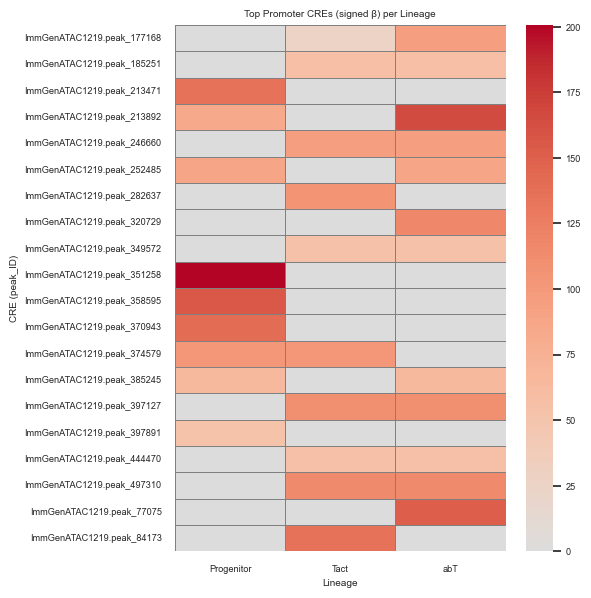

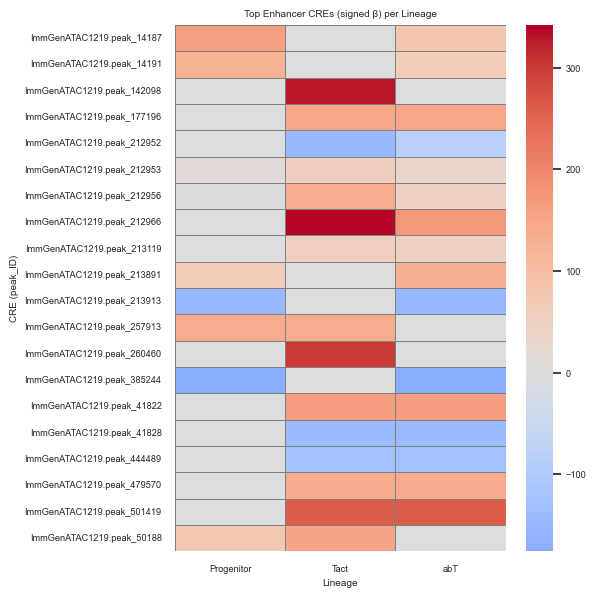

In [24]:
# Plot CREs divided as enhancers and promoters per cell lineage considering effect direction

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Split out promoters / enhancers if you like
prom_df     = merged[merged["role"] == "promoter"]
enh_df      = merged[merged["role"].isin(["activator","repressor"])]

def plot_signed_heatmap(df, title, top_n=20):
    # pick top N by absolute effect size
    top_peaks = (df.groupby("peak_ID")["coefficient"]
                   .apply(lambda x: x.abs().sum())
                   .nlargest(top_n)
                   .index)
    sub = df[df["peak_ID"].isin(top_peaks)]
    
    # pivot on signed coefficient
    heat = (sub.pivot_table(
              index="peak_ID",
              columns="Group",
              values="coefficient",   # **signed** now
              aggfunc="mean",
              fill_value=0
            ))
    
    plt.figure(figsize=(6, max(4, len(heat)*0.3)))
    sns.heatmap(
        heat,
        cmap="coolwarm",        # diverging map
        center=0,               # zero = white
        linewidths=0.5, 
        linecolor="gray"
    )
    plt.title(title)
    plt.xlabel("Lineage")
    plt.ylabel("CRE (peak_ID)")
    plt.tight_layout()
    plt.show()

# Plot
plot_signed_heatmap(prom_df, "Top Promoter CREs (signed β) per Lineage")
plot_signed_heatmap(enh_df,  "Top Enhancer CREs (signed β) per Lineage")


**Fig. 3: Top 20 promoter (above) and enhancer (below) CREs per cell lineage considering effect direction**

Fig. 3 (above):

The promoters cleanly partition into three classes—those that turn on in early progenitors, those that peak in fully mature abT cells, and a handful that track smoothly through all stages. This underscores a modular switch‐like logic at the promoter level, gating which genes are even “open for business” at each developmental step.

- Strong lineage‐specific promoters
    - ImmGenATAC1219.peak_351258 is by far the strongest progenitor promoter (deep red in the Progenitor column), but nearly silent in Tact/abT.
    - ImmGenATAC1219.peak_213892 shows the opposite pattern: it’s the dominant abT promoter, with very little activity earlier.

- Intermediate‐activity promoters
    - Peaks like peak_177168, peak_246660, and peak_252485 have moderate positive β in multiple lineages (salmon tones), suggesting they drive basal expression across several stages.

- “Off” states
    - Gray cells indicate β≈0 (no net promoter effect). Many promoters are essentially off outside their key lineage.

Fig. 3 (below):

Enhancers exhibit a richer palette than promoters: not only lineage specificity, but also the ability to switch between activation and repression depending on cell state. This dynamism likely underpins fine‐tuned modulation of gene networks—boosting some targets robustly in one context while actively silencing them in another.

- Positive vs. negative β (activator vs. repressor)
    - Hot reds are strong activators (β≫0), icy blues are net repressors (β≪0).
    - For example, peak_142098 is a very strong Tact activator (deep red in Tact), but nearly neutral in the others.
    - Conversely, peak_257913 is a weak Tact repressor (light blue), hinting it may dampen certain genes in that state.

- Mixed‐function enhancers
    - Some peaks (e.g. peak_212952) show opposing roles: slightly repressive in Progenitor but activating in abT. That flip suggests context‐dependent cofactor recruitment.

- Pan‐lineage modulators
    - A few, like peak_260460, are positively engaged in all three (salmon across the board), which may correspond to housekeeping or structural regulatory elements.

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


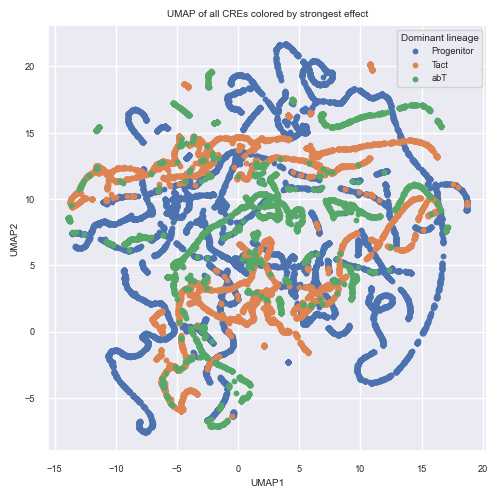

In [ ]:
# Plot all CREs by strongest effect considering effect direction (activation vs. repression)

from umap import UMAP
coords = UMAP(n_components=2, random_state=0).fit_transform(heat)

import numpy as np
import matplotlib.pyplot as plt

# find max lineage per CRE
dominant = heat.abs().idxmax(axis=1)

plt.figure(figsize=(5,5))
for lin in heat.columns:
    sel = dominant == lin
    plt.scatter(coords[sel,0], coords[sel,1], label=lin, s=10)
plt.legend(title='Dominant lineage')
plt.title('UMAP of all CREs colored by strongest effect')
plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()


**Fig. 4: UMAP of all CREs colored by strongest effect**

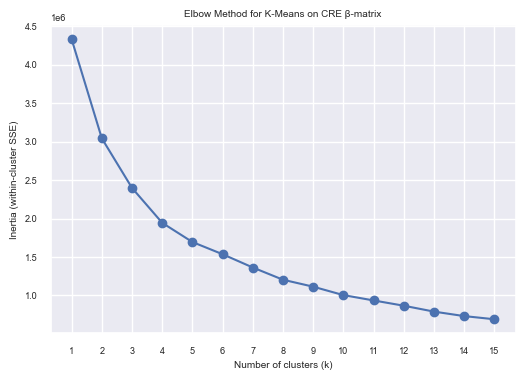

In [ ]:
# Elbow method for K-means clustering on CREs

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Pivot to a CRE × lineage matrix of mean absolute β
heat = (
    merged
    .pivot_table(
        index="peak_ID",
        columns="Group",
        values="abs_coef",
        aggfunc="mean",
        fill_value=0
    )
)

# Prepare range of k and storage
ks = list(range(1, 16))
inertias = []

# Compute inertia for each k
X = heat.values
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o', linestyle='-')
plt.xticks(ks)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method for K-Means on CRE β-matrix")
plt.grid(True)
plt.show()


**Fig. 5: Elbow method for k-means on CRE ß-matrix**

The graph shows the optimal number of clusters to be at k = 3.

c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\kalin_p\miniconda3\envs\REAL_FORKED_Bioinfo_project\lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


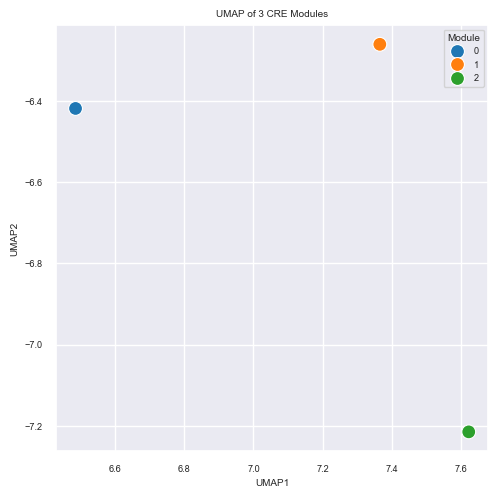

In [ ]:
# Plot UMAP of CRE modules as centroids

from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

# Build CRE×lineage coefficient matrix
heat = merged.pivot_table(
    index="peak_ID",
    columns="Group",
    values="coefficient",
    aggfunc="mean",
    fill_value=0
)

# Cluster into 3 modules
k = 3
labels = KMeans(n_clusters=k, random_state=0, n_init="auto").fit_predict(heat)
heat["module"] = labels

# Compute centroids
centroids = heat.groupby("module").mean().values

# UMAP on centroids with random init
embedding = UMAP(
    n_components=2,
    init="random",
    random_state=0
).fit_transform(centroids)

# Plot
plt.figure(figsize=(5,5))
sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    hue=list(range(k)),
    palette="tab10",
    s=100,
    legend="full"
)
plt.title("UMAP of 3 CRE Modules")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Module")
plt.tight_layout()
plt.show()


**Fig. 6: UMAP of 3 CRE modules**

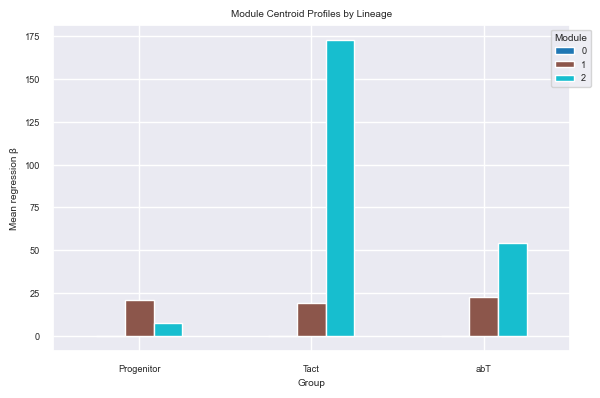

In [ ]:
# Plot module centroid profiles per cell lineage

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Re‐build your CRE×lineage signed‐β matrix
heat = merged.pivot_table(
    index="peak_ID",
    columns="Group",
    values="coefficient",
    aggfunc="mean",
    fill_value=0
)

# Run k-means (k=3) and attach labels
labels = KMeans(n_clusters=3, random_state=0, n_init="auto").fit_predict(heat)
heat['module'] = labels

# Select just the numeric β-columns
lineage_cols = [c for c in heat.columns if c != 'module']

# Compute module centroids (mean β per lineage)
module_profiles = (
    heat
    .groupby('module')[lineage_cols]
    .mean()           # pandas ≥1.5 will default to numeric_only=True here
)

# Plot grouped bar chart of those centroids
ax = module_profiles.T.plot(
    kind='bar',
    figsize=(6,4),
    colormap='tab10'
)
ax.set_ylabel('Mean regression β')
ax.set_title('Module Centroid Profiles by Lineage')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Module', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()



**Fig. 7: Module centroid profiles by cell lineage**

This bar‐chart shows the average signed regression β-coefficients for each of the three CRE-modules, broken down by the three T-cell lineages (Progenitor, Tact, abT).

- Module 0 (blue):
    - Very low mean β across all lineages.
    - These CREs have only tiny (near‐zero) effects on gene expression, regardless of lineage. They likely represent “weak” or non-specific regulatory elements.
    - Likely include either spurious peaks or ones whose contribution is too subtle to matter in this comparison.

- Module 1 (brown)
    - Moderate, roughly equal mean β (~20) in Progenitor, Tact, and abT.
    - These CREs appear to act as pan-lineage regulators — they modestly influence gene expression in all three cell stages but don’t distinguish between them.
    - May correspond to housekeeping or general T-cell regulatory elements that keep a baseline program on in all lineages.

- Module 2 (cyan)
    - A very large mean β in Tact (~175), a smaller but still positive mean in abT (~50), and low in Progenitor (~5).
    - This module contains the CREs that are highly specific to the activated T-cell stage (Tact), with a spill-over effect in the downstream abT state but essentially no role in the progenitor.
    - The CREs here drive the strongest up-regulation of target genes precisely in activated T cells.

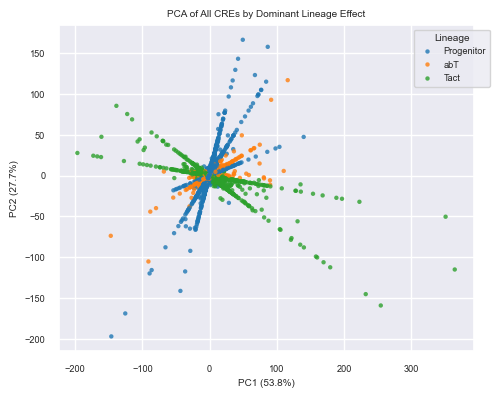

In [ ]:
# Plot PCA of all CREs by dominant lineage effect

from sklearn.decomposition import PCA
import seaborn as sns

# PCA on the heat matrix (CREs × 3 lineages)
pca = PCA(n_components=2, random_state=0)
coords = pca.fit_transform(heat.iloc[:, :-1])  # omit the module column

# Determine dominant lineage again
dominant = heat.iloc[:, :-1].abs().idxmax(axis=1)

# Scatter PCA
plt.figure(figsize=(5,4))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=dominant,
    palette='tab10',
    s=10,
    alpha=0.8,
    linewidth=0
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of All CREs by Dominant Lineage Effect")
plt.legend(title='Lineage', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


**Fig. 8: PCA of all CREs by dominant lineage effect**

- PC1 (x-axis, 53.8 % variance)
    - Largely encodes the overall magnitude of β across lineages.
    - Rightward points tend to be CREs with strong positive effects overall (especially on Progenitor genes, the blue dots).
    - Leftward points are CREs whose net effect is strongest in Tact (the green dots cluster here).

- PC2 (y-axis, 27.7 % variance)
    - Captures the contrast between abT versus the other two lineages.
    - Upward (positive PC2) tends to enrich for CREs more active in abT (orange), whereas downward (negative PC2) enriches those even more Tact-specific.

The blue “Progenitor” CREs fan out mostly along high PC1, confirming they drive genes early in development. Green “Tact” CREs spread toward low PC1 and negative PC2, marking a distinct regulatory program. Orange “abT” CREs sit between, with moderate PC1 and positive PC2, showing their intermediate but still distinct role.


Overall, PCA confirms that the CREs really do fall into three “clouds” matching the three lineage-specific modules we saw in k-means/UMAP:

- Progenitor module (strong, early effects),
- Tact module (strong, late effects),
- abT module (intermediate profile).